# Signature Verification using Siamese Neural Networks

In this notebook, we will develop a ***Siamese Neural Network (SNN)*** to detect and verify the authenticity of signatures. Signature verification is a critical task in various applications, including banking and legal documentation, where identifying counterfeit signatures can prevent fraud. By leveraging a Siamese architecture, we will train the model to learn the similarity between pairs of signatures and classify them as either "original" or "forged." This approach allows us to compare two inputs directly, enhancing the model's ability to discern subtle differences between authentic and counterfeit signatures.

## Installing and Importing Libraries

In [1]:
!pip install visualkeras

In [9]:
# Import Libraries
import cv2
import numpy as np
import visualkeras
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D

## Defining Constants

In [3]:
# Constants
IMAGE_WIDTH = 500
IMAGE_HEIGHT = 250
THRESHOLD = 240
IMAGE_BASE_PATH = '/kaggle/input/signature-matching/custom/full/'

## Image Preprcoessing and Data Augmenting

1. **Define the Image Path**: Combines the base path with the image file name to create the full image path.
2. **Load the Image in Grayscale**: Uses OpenCV to read the image in grayscale mode.
3. **Apply Thresholding**: Applies a binary threshold to the grayscale image, converting it into a binary format.
4. **Resize the Image**: Resizes the thresholded image to a specified width and height.
5. **Normalize the Image**: Scales the pixel values to a range between 0 and 1.
6. **Stack the Image**: Converts the 2D grayscale image into a 3D format by stacking the same data across three channels.

In [4]:
# Define the data augmentation generator, excluding flipping and mirroring
datagen = ImageDataGenerator(rotation_range=15,     # Random rotation
                             width_shift_range=0.2,  # Horizontal shift
                             height_shift_range=0.2, # Vertical shift
                             shear_range=0.2,        # Shearing
                             zoom_range=0.1,         # Random zoom
                             fill_mode='nearest')    # Fill mode to handle pixels after transformation

In [5]:
# Function to preprocess images with optional data augmentation
def preprocess_image(image_path, is_augment=False):
    # Complete the image path
    full_image_path = IMAGE_BASE_PATH + image_path
    
    # Load the image in grayscale
    image = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply thresholding
    _, thresh_image = cv2.threshold(image, THRESHOLD, 255, cv2.THRESH_BINARY)
    
    # Resize the image
    resized_image = cv2.resize(thresh_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    # Normalize the image
    normalized_image = resized_image / 255.0
    
    # Stack the grayscale image into 3 dimensions
    stacked_image = np.stack([normalized_image] * 3, axis=-1)  # Converts (H, W) -> (H, W, 3)
    
    if is_augment:
        # Apply data augmentation if needed
        img_augmented = datagen.random_transform(stacked_image)
        return img_augmented
    
    return stacked_image

## Defining Dataset for Training and Testing

In [6]:
# Load train and test data from CSV files
train_df = pd.read_csv('/kaggle/input/signature-matching/custom/train_data.csv', header=0)
test_df = pd.read_csv('/kaggle/input/signature-matching/custom/test_data.csv', header=0)

# Take only the first 1400 rows for train data
train_df = train_df.iloc[:1500]

# Take only the first 600 rows for test data
test_df = test_df.iloc[:650]

# Preprocess all images from the train dataset with augmentation
train_image_pairs = [(preprocess_image(row[0], is_augment=True), 
                      preprocess_image(row[1], is_augment=True)) 
                     for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing Train Images")]

# Preprocess all images from the test dataset without augmentation
test_image_pairs = [(preprocess_image(row[0]), 
                     preprocess_image(row[1])) 
                    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing Test Images")]

# Convert the pairs into arrays
train_image_pairs = [np.stack([img1, img2], axis=0) for img1, img2 in train_image_pairs]
test_image_pairs = [np.stack([img1, img2], axis=0) for img1, img2 in test_image_pairs]

# Convert into numpy arrays
train_image_pairs = np.array(train_image_pairs)
test_image_pairs = np.array(test_image_pairs)

Processing Train Images:   0%|          | 0/1500 [00:00<?, ?it/s]/tmp/ipykernel_629/2442048110.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_image_pairs = [(preprocess_image(row[0], is_augment=True),
/tmp/ipykernel_629/2442048110.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preprocess_image(row[1], is_augment=True))
Processing Test Images:   0%|          | 0/650 [00:00<?, ?it/s]/tmp/ipykernel_629/2442048110.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [7]:
# Defining labels
train_labels = train_df.iloc[:, 2].values
test_labels = test_df.iloc[:, 2].values

# Count 0s and 1s in train_labels
train_zeros = np.sum(train_labels == 0)
train_ones = np.sum(train_labels == 1)

# Count 0s and 1s in test_labels
test_zeros = np.sum(test_labels == 0)
test_ones = np.sum(test_labels == 1)

# Print the results
print("Training labels: 0s =", train_zeros, ", 1s =", train_ones)
print("Testing labels: 0s =", test_zeros, ", 1s =", test_ones)

Training labels: 0s = 715 , 1s = 785
Testing labels: 0s = 302 , 1s = 348


We can see that the class is minutely imbalanced, so we can ignore focal loss.

## Defining The ConvNet and The Siamese Neural Network

In [10]:
# Build the base convolutional model
def build_convnet(input_shape):
    convnet = tf.keras.Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('mish'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('mish'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('mish'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dropout(0.5),
        Dense(1024),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.5),
        Dense(512),
        BatchNormalization(),
        Activation('sigmoid'),
    ])
    return convnet

# Function to compute the absolute difference (L1 distance) between two embeddings
def l1_distance(vectors):
    x, y = vectors
    return tf.abs(x - y)

# Input shape for a single image
input_shape = (250, 500, 3)

# Input layers for the two images
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Base model to encode the images into feature vectors
base_model = build_convnet(input_shape)

# Pass both inputs through the base model
encoded_a = base_model(input_a)
encoded_b = base_model(input_b)

# Compute the L1 distance between the encoded representations
l1_dist = Lambda(l1_distance)([encoded_a, encoded_b])

# Fully connected layers for classification
x = Dense(128, activation='mish', kernel_regularizer=l2(0.01))(l1_dist)  # L2 Regularization
x = Dropout(0.5)(x)
x = Dense(64, activation='mish', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Build the final Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

## Visualizations

In [11]:
# Customize the colors for the visualization
color_map = defaultdict(dict)  # customize the colors
color_map[Conv2D]['fill'] = '#00f5d4'
color_map[MaxPooling2D]['fill'] = '#8338ec'
color_map[Dropout]['fill'] = '#03045e'
color_map[Dense]['fill'] = '#fb5607'
color_map[Flatten]['fill'] = '#ffbe0b'

# Visualize the ConvNet model with customized colors
visualkeras.layered_view(base_model, 
                         to_file='/kaggle/working/ConvNet_Model_Visualization.png', 
                         legend=True,
                         color_map=color_map)
base_model.summary()

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 250, 500, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 250, 500, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 250, 500, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 125, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 125, 250, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 125, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 62, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 62, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 62, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 31, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 31, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 31, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 15, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 15, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 15, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 57,154,752 (218.03 MB)

 Trainable params: 57,149,696 (218.01 MB)

 Non-trainable params: 5,056 (19.75 KB)

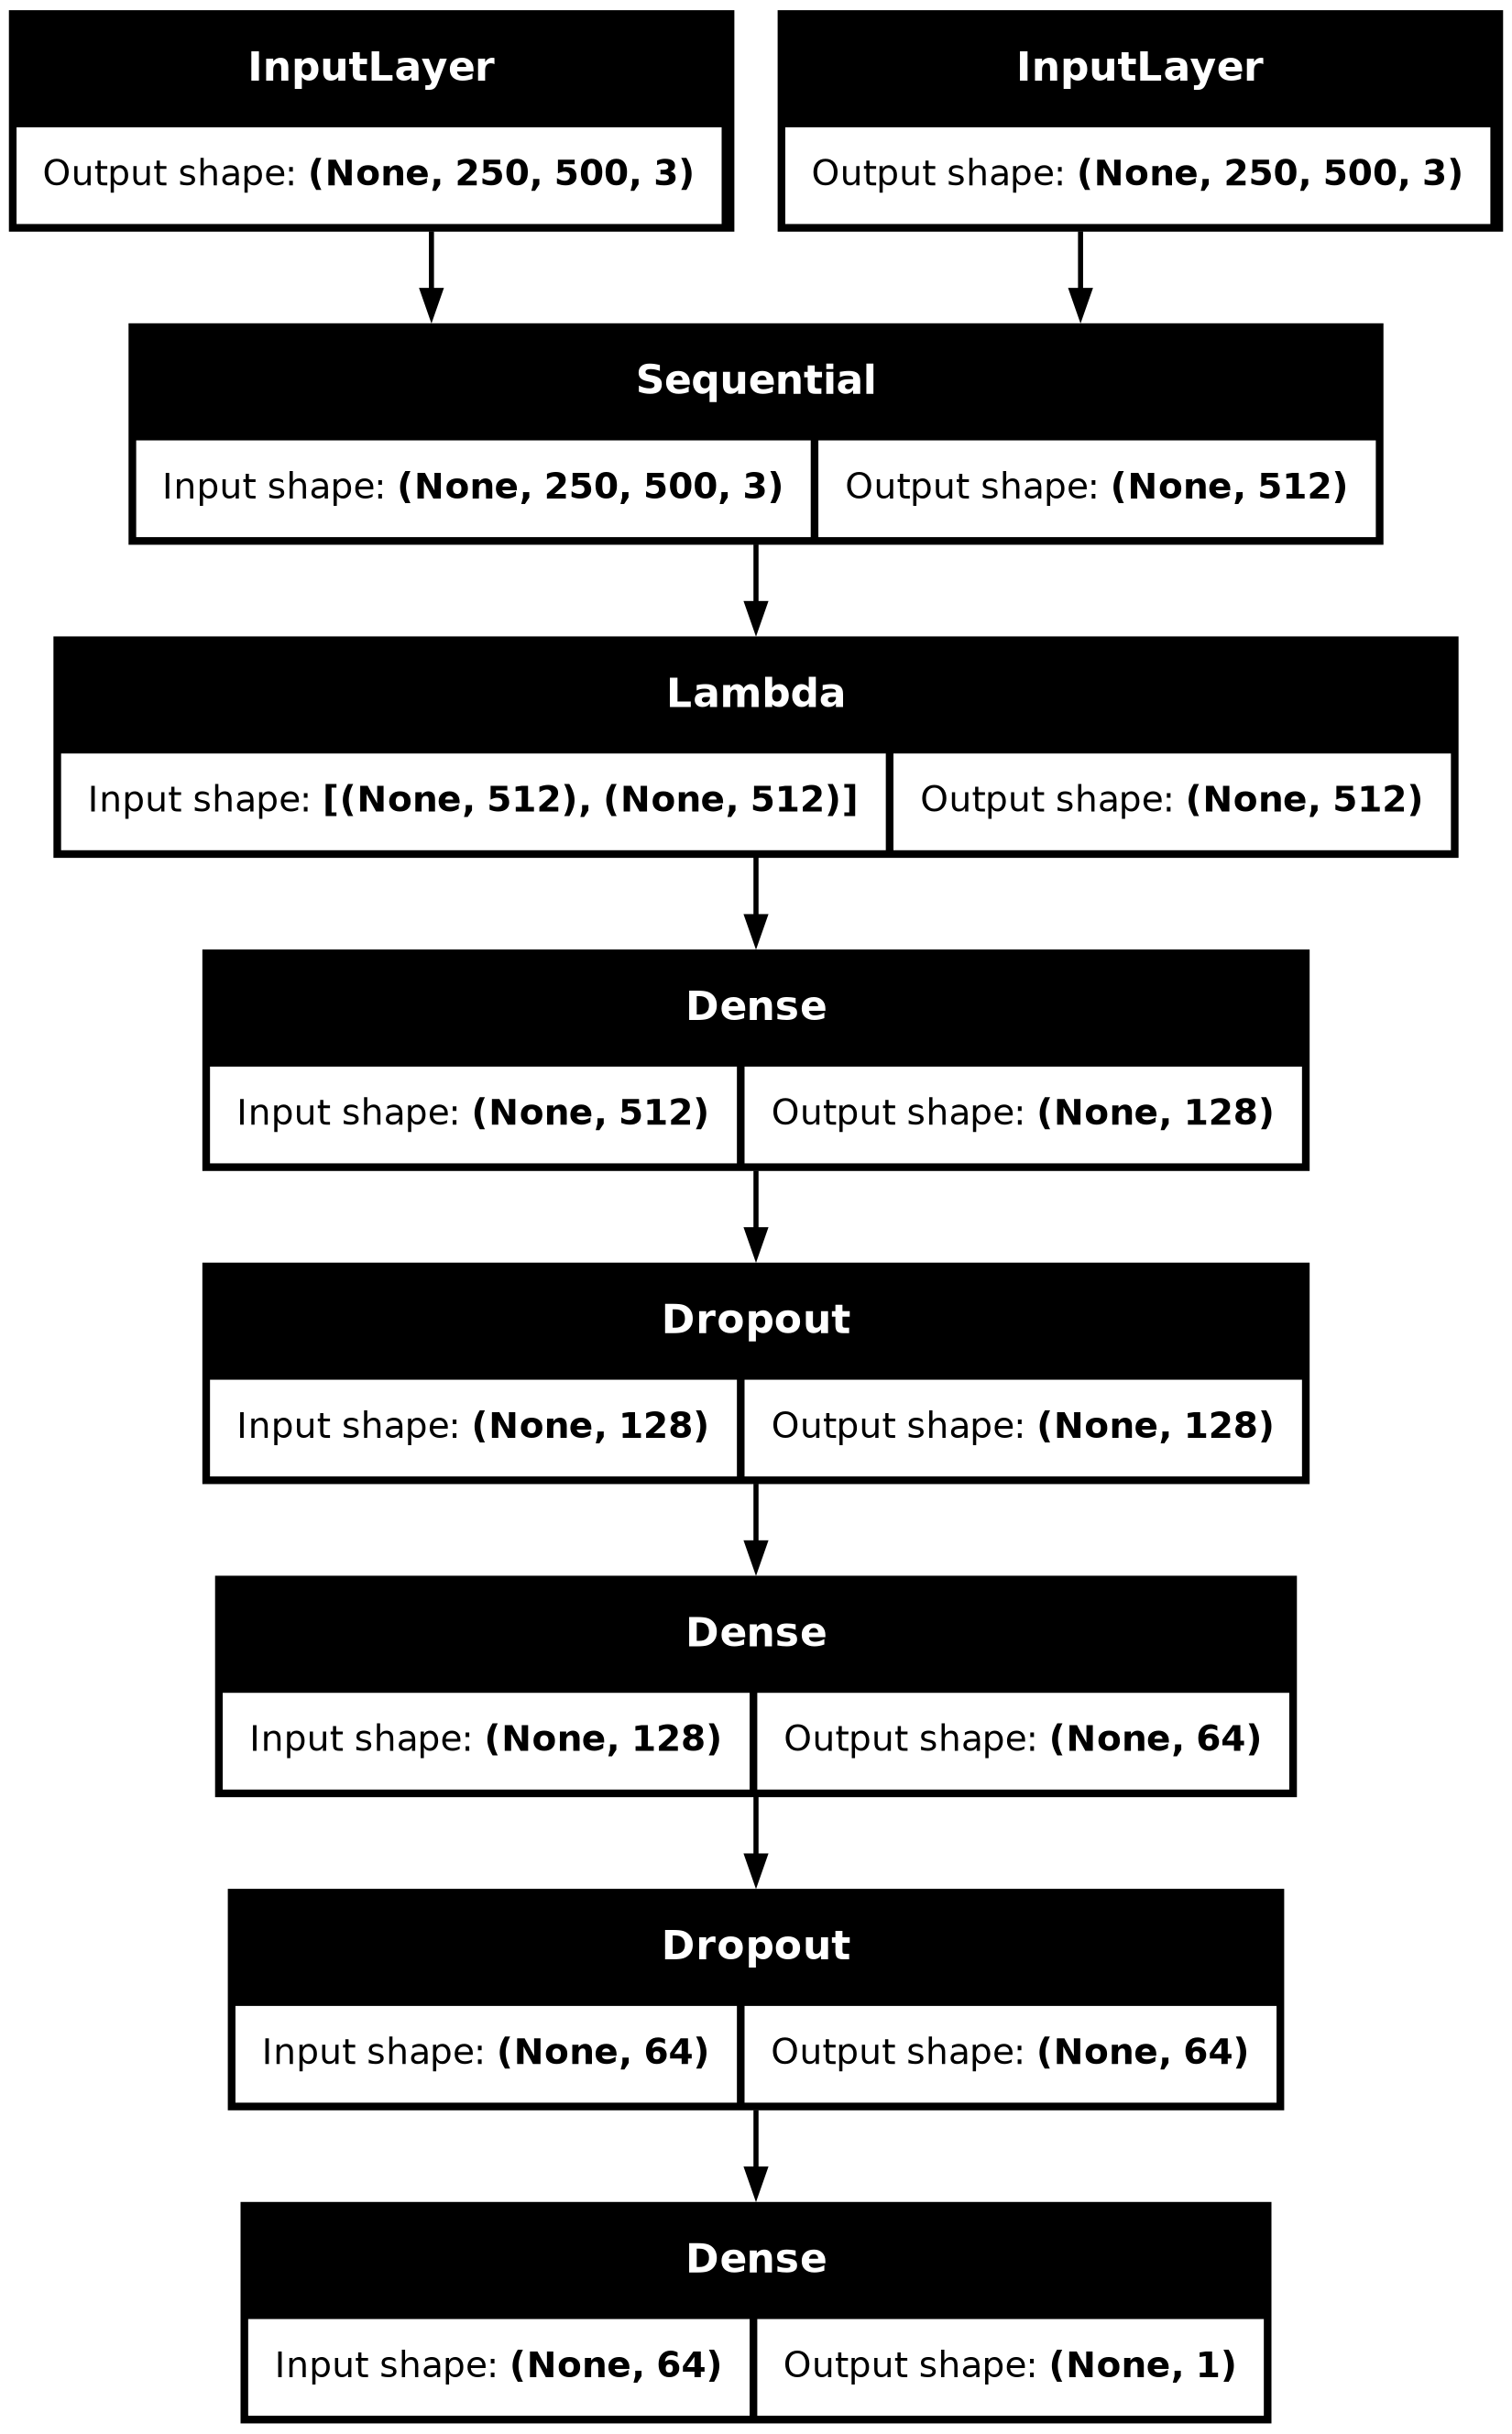

In [24]:
# Save model architecture as a JPG file
tf.keras.utils.plot_model(siamese_model, to_file='siamese_model_plot.png', show_shapes=True)

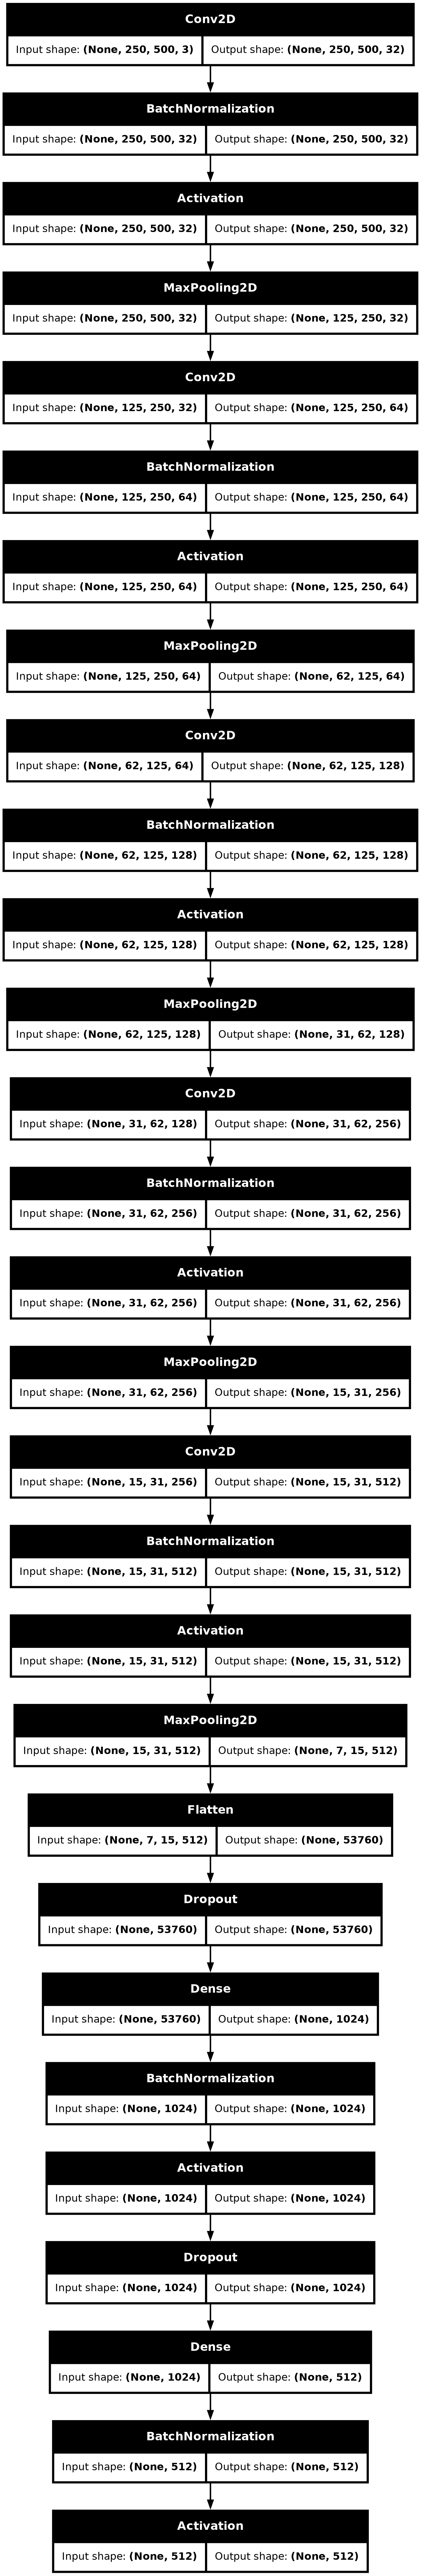

In [23]:
tf.keras.utils.plot_model(base_model, to_file='base_model_plot.png', show_shapes=True)

## Training Starts!

In [13]:
# Prepare training and test data
train_image_1 = train_image_pairs[:, 0]
train_image_2 = train_image_pairs[:, 1]
test_image_1 = test_image_pairs[:, 0]
test_image_2 = test_image_pairs[:, 1]

In [16]:
# Introduce EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=20, 
                               restore_best_weights=True)

In [17]:
# Compile the model
optimizer = Adam(learning_rate=10e-6)
siamese_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[Precision(), 'accuracy'])
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 250, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 250, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 512)       │ 57,154,752 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 512)       │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,228,737 (218.31 MB)

 Trainable params: 57,223,681 (218.29 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [18]:
# Train the Siamese model
history = siamese_model.fit([train_image_1, train_image_2], train_labels, 
                            validation_data=([test_image_1, test_image_2], test_labels),
                            batch_size=16, epochs=60, 
                            callbacks=[early_stopping])

Epoch 1/60


I0000 00:00:1727854309.702077     676 service.cc:145] XLA service 0x7bba4000a8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727854309.702173     676 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/94 ━━━━━━━━━━━━━━━━━━━━ 46:09 30s/step - accuracy: 0.7500 - loss: 3.5002 - precision_1: 0.6667

I0000 00:00:1727854332.202743     676 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 73s 470ms/step - accuracy: 0.5197 - loss: 3.5720 - precision_1: 0.5370 - val_accuracy: 0.8215 - val_loss: 3.5376 - val_precision_1: 0.8053
Epoch 2/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.5859 - loss: 3.5169 - precision_1: 0.6010 - val_accuracy: 0.7738 - val_loss: 3.4209 - val_precision_1: 0.7930
Epoch 3/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.6207 - loss: 3.4598 - precision_1: 0.6190 - val_accuracy: 0.8569 - val_loss: 3.2538 - val_precision_1: 0.8244
Epoch 4/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.6619 - loss: 3.4143 - precision_1: 0.6518 - val_accuracy: 0.8800 - val_loss: 3.1862 - val_precision_1: 0.8409
Epoch 5/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.7207 - loss: 3.3555 - precision_1: 0.6950 - val_accuracy: 0.8908 - val_loss: 3.1384 - val_precision_1: 0.8579
Epoch 6/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.7081 - loss: 3.3151 - precision_1: 0.6878 - val_accuracy: 0

## Metric Evaluations

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step
Accuracy: 0.9230769230769231
Precision: 0.9331395348837209
Recall: 0.9224137931034483
F1 Score: 0.9277456647398844
True Positives: 321
True Negatives: 279
False Positives: 23
False Negatives: 27


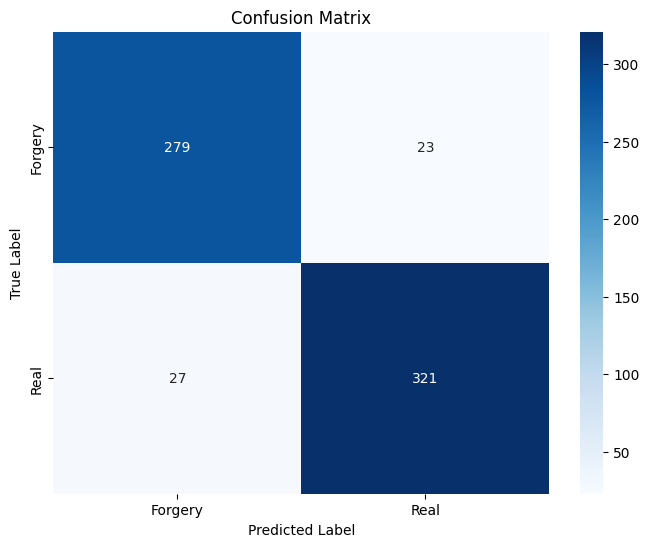

In [19]:
# Split the test_image_pairs into two arrays for prediction
test_image_1 = test_image_pairs[:, 0]  # First image in pair
test_image_2 = test_image_pairs[:, 1]  # Second image in pair

# Predict using the trained Siamese network
predictions = siamese_model.predict([test_image_1, test_image_2])

# Convert probabilities to binary predictions (threshold = 0.5)
pred_labels = (predictions > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Create a confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Calculate True Positives, True Negatives, False Positives, False Negatives
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Print the confusion matrix values
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Real'], yticklabels=['Forgery', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the plot to the specified directory
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

## Plotting Graphs

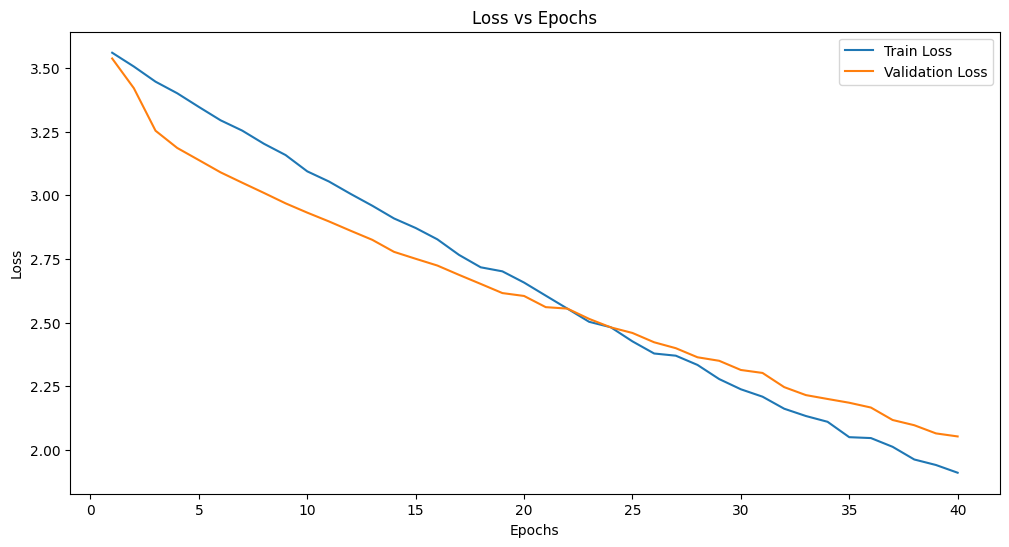

<Figure size 640x480 with 0 Axes>

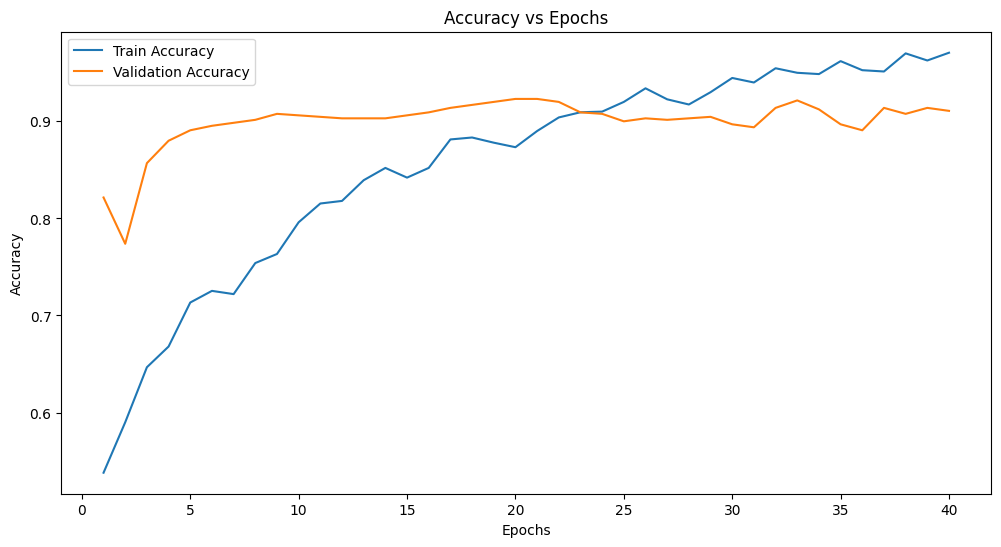

<Figure size 640x480 with 0 Axes>

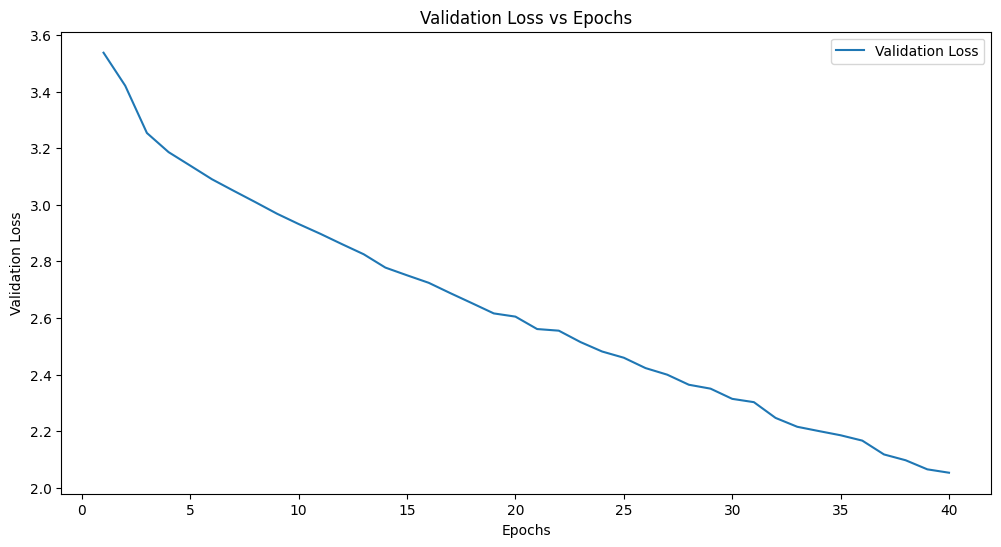

<Figure size 640x480 with 0 Axes>

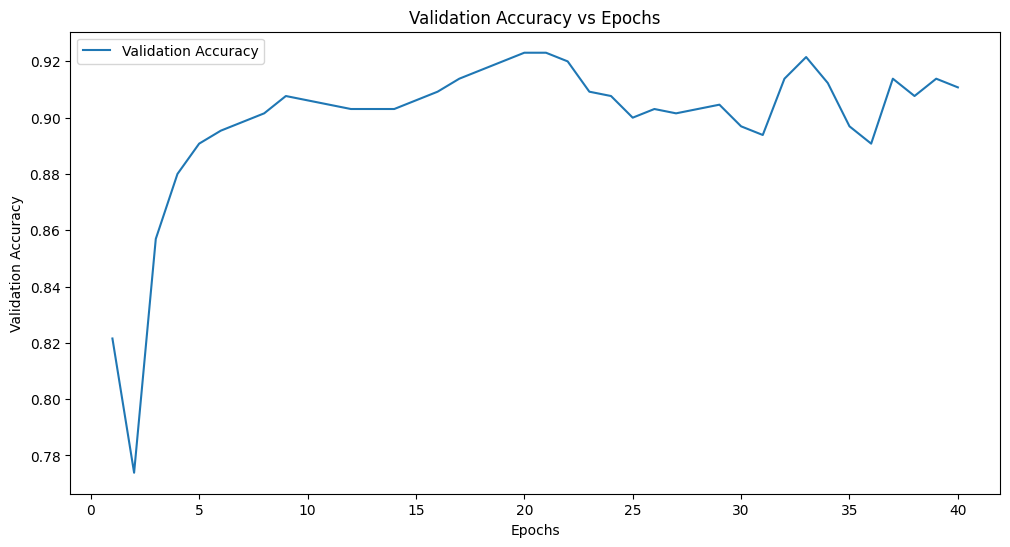

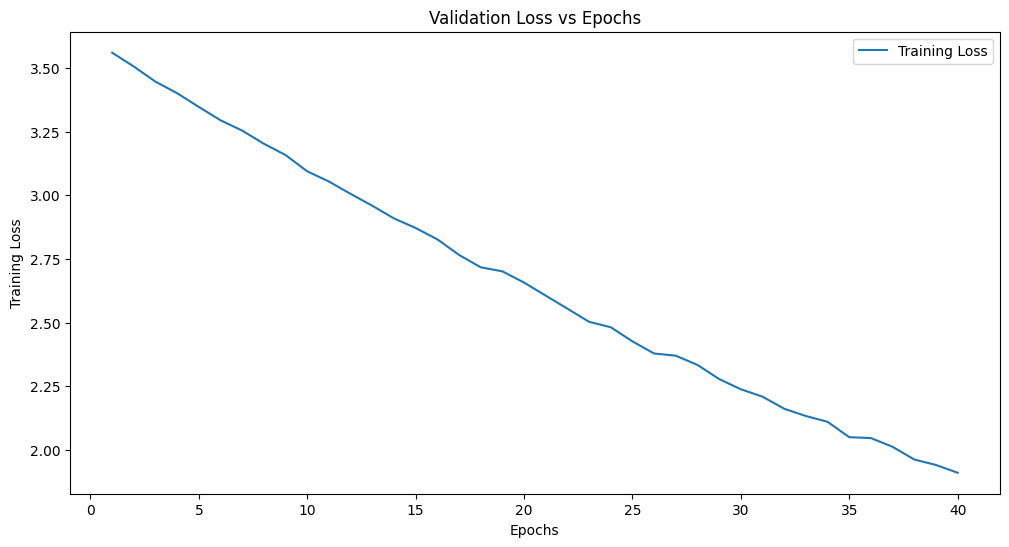

<Figure size 640x480 with 0 Axes>

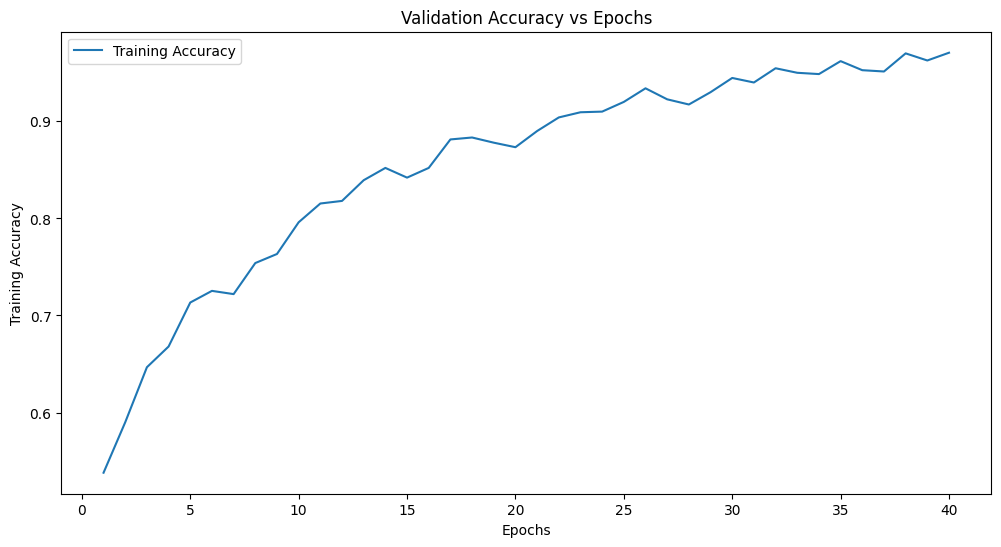

In [20]:
# Plot training metrics
def plot_metrics(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Create and save the Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'/kaggle/working/LossPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Loss
    plt.clf()  # Clear the figure for the next plot

    # Create and save the Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'/kaggle/working/AccuracyPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Accuracy
    plt.clf()  # Clear the figure for the next plots

    # Create and save the Validation Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.savefig(f'/kaggle/working/Val_LossPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Validation Loss
    plt.clf()  # Clear the figure for the next plot

    # Create and save the Validation Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.savefig(f'/kaggle/working/Val_AccuracyPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Validation Accuracy
    
    # Create and save the Validation Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.title('Validation Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.savefig(f'/kaggle/working/Train_LossPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Validation Loss
    plt.clf()  # Clear the figure for the next plot

    # Create and save the Validation Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.legend()
    plt.savefig(f'/kaggle/working/Train_AccuracyPlot.png', bbox_inches='tight')
    plt.show()  # Display the plot for Validation Accuracy

# Call the function to plot the metrics
plot_metrics(history)

## Saving the Model

In [21]:
# Save the model to directory
siamese_model.save('/kaggle/working/Siamese_Model.h5')

In [22]:
print("Complete")

Complete


## AND WE ARE DONE!